In [ ]:
"""
--- Cu Standard EXAFS Fitting w/ Multiple Scattering Paths --- 

This example demostrates EXAFS fitting of a Cu foil standard with multiple scattering path using xraylarch.
A custom module featuring parameter table is used.

"""

In [1]:
# Base packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', None)

import os
import h5py

# Packages for reading data and normalisation
from larch import Group
from larch.xafs import autobk, xftf

from tools import exafs_param_table as pt

# Packages for EXAFS fittings
from larch.xafs import feffit_transform, feffit_dataset, feffit

# Packages for reading EXAFS fittings results
from larch.xafs import feffit_report
from lmfit import fit_report

from tools import io_results 

[root] WARNING : Larchs apps and shell are not supported due to missing dependencies: cannot import name 'LarchWxApp' from 'larch.wxlib' (D:\Python\Anaconda3\envs\xraylarch\lib\site-packages\larch\wxlib\__init__.py)


In [2]:
""" 
Data Reading and Pre-processing

Notes: 
1.  Data is read from .nxs file and loaded into a larch group from scratch.

2.  The data loaded was normalised via DAWN. To suppress auto-normalisation in Larch, 
    the pre_edge_kws are added to force a 1st degree polynomial fit for post-edge.
    
WIP: define data directly as normalised data

"""
file_path = "data\\exafs_fitting\\Cu_foil_STD_merge_norm.nxs" # Normalised .nxs file

# Reading .nxs by h5py
file = h5py.File(file_path, "r")
energy = np.array(file["processed"]["result"]["energy"])
data = np.array(file["processed"]["result"]["data"])

# Loading into a larch group and autobk (see note 2)
std_cu = Group(name="Cu Standard", energy=energy, mu=data)
autobk(std_cu, pre_edge_kws={"nnorm": 0, "nvict": 0}, rbkg=1.0) 
xftf(std_cu, kmin=3.0, kmax=12.0, dk=0.5, window="hanning", kweight=2.00, rbkg=1.0)

Text(0, 0.5, 'Normalised absorption')

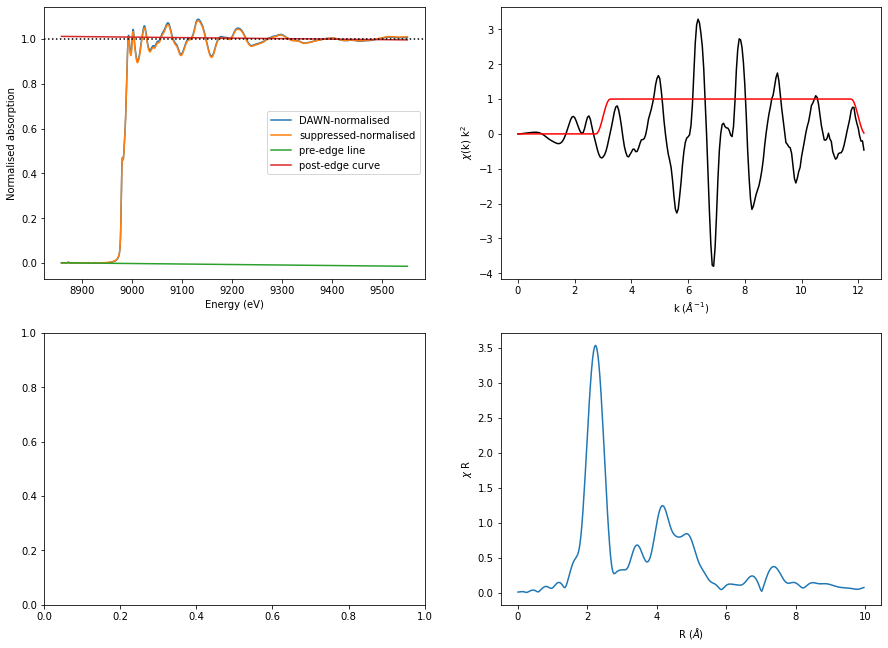

In [3]:
""" Misc: Inspecting the suppressed normalisation result. """
fig, ax = plt.subplots(2, 2, figsize=(15, 11))

ax[0, 0].plot(std_cu.energy, std_cu.mu, label='DAWN-normalised')
ax[0, 0].plot(std_cu.energy, std_cu.norm, label='suppressed-normalised')
ax[0, 0].plot(std_cu.energy, std_cu.pre_edge, label='pre-edge line')
ax[0, 0].plot(std_cu.energy, std_cu.post_edge, label='post-edge curve')
ax[0, 0].axhline(1, linestyle=":", color="k")

ax[0, 1].plot(std_cu.k, std_cu.chi * std_cu.k ** 2, label="k-space", color="k")
ax[0, 1].plot(std_cu.k, std_cu.kwin, label="FT window", color="r")
ax[0, 1].set_xlabel("k ($\AA^{-1}$)")
ax[0, 1].set_ylabel("$\chi$(k) k$^2$")

ax[1, 1].plot(std_cu.r, std_cu.chir_mag)
ax[1, 1].set_xlabel("R ($\AA$)")
ax[1, 1].set_ylabel("$\chi$ R")

ax[0, 0].legend()
ax[0, 0].set_xlabel("Energy (eV)")
ax[0, 0].set_ylabel("Normalised absorption")

In [4]:
"""
A parameters table with all available scattering paths is loaded for EXAFS fitting.
    1. effective R and degenerary are read from the feff file.

Notes: Param tables are stored as pandas dataframes, which means
    - Param table can be manipulated as any pandas dataframe.
    - Param table can be import/export as .csv files.

Here feff paths up to R = 7 angstrom are stored.

"""
feff_folder =  r"data/feffs/Cu1_K_c7_Copper_cif11145"
feff_table = pt.param_table(feff_folder)
feff_table

files.dat found, returning dataframe.
files.dat found, returning formula.


,scatter material,spectra,nlegs,reff,shell,amp ratio,s02,e0,degen,sigma2,deltar,fpath
0,Cu,spectra,2,2.5562,shell,100.000,s02,e0,12.0,sigma2,deltar,data/feffs/Cu1_K_c7_Copper_cif11145\feff0001.dat
1,Cu,spectra,2,3.6150,shell,22.990,s02,e0,6.0,sigma2,deltar,data/feffs/Cu1_K_c7_Copper_cif11145\feff0002.dat
2,Cu,spectra,3,3.8342,shell,12.310,s02,e0,48.0,sigma2,deltar,data/feffs/Cu1_K_c7_Copper_cif11145\feff0003.dat
3,Cu,spectra,3,4.3636,shell,9.392,s02,e0,48.0,sigma2,deltar,data/feffs/Cu1_K_c7_Copper_cif11145\feff0004.dat
4,Cu,spectra,2,4.4274,shell,55.800,s02,e0,24.0,sigma2,deltar,data/feffs/Cu1_K_c7_Copper_cif11145\feff0005.dat
5,Cu,spectra,3,4.7699,shell,11.750,s02,e0,48.0,sigma2,deltar,data/feffs/Cu1_K_c7_Copper_cif11145\feff0006.dat
6,Cu,spectra,3,4.7699,shell,25.390,s02,e0,96.0,sigma2,deltar,data/feffs/Cu1_K_c7_Copper_cif11145\feff0007.dat
7,Cu,spectra,2,5.1123,shell,19.160,s02,e0,12.0,sigma2,deltar,data/feffs/Cu1_K_c7_Copper_cif11145\feff0008.dat
8,Cu,spectra,3,5.1123,shell,9.608,s02,e0,12.0,sigma2,deltar,data/feffs/Cu1_K_c7_Copper_cif11145\feff0009.dat
9,Cu,spectra,3,5.1123,shell,44.490,s02,e0,24.0,sigma2,deltar,data/feffs/Cu1_K_c7_Copper_cif11145\feff0010.dat


In [5]:
"""
A general strategy in approaching multipaths fitting. (Approach by Shelly Kelly)
    1. Include paths within interested R range
    2. Determine corresponding shell based on R effective
    3. Group sigma2 based on shell number
    4. Separate e0 into 1st shell and the rest
    5. Introduce expansion/contraction factor (alpha) with deltar

A new dataframe with all the necessary parameters are stored.

A different fitting strategy can be formulated, as long as the dataframe is properly filled.

Only these parameters are read into larch fitting
    - s02
    - e0
    - degen
    - sigma2
    - deltar
    - reff (read as parameter, however not in EXAFS equation)
    - fpath

"""

# 1. Fitting all paths up to R = 6.5
fit_table = feff_table[feff_table["reff"] < 6.5]

# 2. Assume paths with same reff belongs to the same shell
fit_table = pt.form_shells(fit_table)

# 3. Group sigma2 based on shell
fit_table = pt.groupby_shell(fit_table, ["sigma2"])
# fit_table = pt.independent_params(fit_table, ["sigma2"])

# 4. Separate e0 into 1st shell and the rest
fit_table = pt._1st_shell_e0(fit_table)

# 5. Introduce expansion/contraction factor (alpha)
fit_table["deltar"] = "reff*alpha"
fit_table.insert(11, "alpha", "alpha") # Add a new column for alpha

# Note the subscripts added when grouped by scattering shell
fit_table

,scatter material,spectra,nlegs,reff,shell,amp ratio,s02,e0,degen,sigma2,deltar,alpha,fpath
0,Cu,spectra,2,2.5562,1,100.000,s02,e0_s1,12.0,sigma2_s1,reff*alpha,alpha,data/feffs/Cu1_K_c7_Copper_cif11145\feff0001.dat
1,Cu,spectra,2,3.6150,2,22.990,s02,e0_s2,6.0,sigma2_s2,reff*alpha,alpha,data/feffs/Cu1_K_c7_Copper_cif11145\feff0002.dat
2,Cu,spectra,3,3.8342,3,12.310,s02,e0_s2,48.0,sigma2_s3,reff*alpha,alpha,data/feffs/Cu1_K_c7_Copper_cif11145\feff0003.dat
3,Cu,spectra,3,4.3636,4,9.392,s02,e0_s2,48.0,sigma2_s4,reff*alpha,alpha,data/feffs/Cu1_K_c7_Copper_cif11145\feff0004.dat
4,Cu,spectra,2,4.4274,5,55.800,s02,e0_s2,24.0,sigma2_s5,reff*alpha,alpha,data/feffs/Cu1_K_c7_Copper_cif11145\feff0005.dat
5,Cu,spectra,3,4.7699,6,11.750,s02,e0_s2,48.0,sigma2_s6,reff*alpha,alpha,data/feffs/Cu1_K_c7_Copper_cif11145\feff0006.dat
6,Cu,spectra,3,4.7699,6,25.390,s02,e0_s2,96.0,sigma2_s6,reff*alpha,alpha,data/feffs/Cu1_K_c7_Copper_cif11145\feff0007.dat
7,Cu,spectra,2,5.1123,7,19.160,s02,e0_s2,12.0,sigma2_s7,reff*alpha,alpha,data/feffs/Cu1_K_c7_Copper_cif11145\feff0008.dat
8,Cu,spectra,3,5.1123,7,9.608,s02,e0_s2,12.0,sigma2_s7,reff*alpha,alpha,data/feffs/Cu1_K_c7_Copper_cif11145\feff0009.dat
9,Cu,spectra,3,5.1123,7,44.490,s02,e0_s2,24.0,sigma2_s7,reff*alpha,alpha,data/feffs/Cu1_K_c7_Copper_cif11145\feff0010.dat


In [6]:
""" Formulate the feffit parameters and paths using the parameters table (custom module). """

# Setup
feffit_params = pt.setup_feffit_params(fit_table)
feffit_paths = pt.setup_feffit_paths(fit_table)

# Define fit space and forward FT (larch function)
feffit_trans = feffit_transform(kmin=3.0, kmax=12.000, dk=0.500, kw=2,
                                 window="hanning", fitspace='r', rmin=1.000, rmax=6.500)

# Construct fitting dataset 
feffit_datasets = feffit_dataset(data=std_cu, transform=feffit_trans, paths=feffit_paths)

In [7]:
""" Final Fitting. """
feffit_result = feffit(feffit_params, feffit_datasets)     

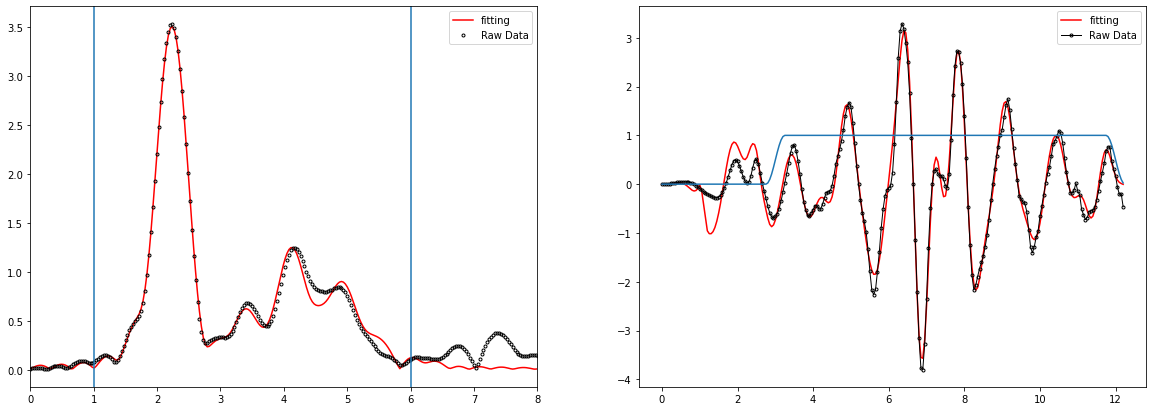

In [8]:
""" Plotting Fitted Results. """
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

spectra = feffit_result.datasets[0].data
fit = feffit_result.datasets[0].model

ax[0].plot(fit.r, fit.chir_mag, color="r", label="fitting")
ax[0].plot(spectra.r, spectra.chir_mag, lw=0, marker='o', markersize=3, fillstyle='none', color="k", label="Raw Data")
ax[0].axvline(1)
ax[0].axvline(6)
ax[0].set_xlim(0, 8)
ax[0].legend()

ax[1].plot(fit.k, fit.chi * fit.k ** 2, color="r", label="fitting")
ax[1].plot(spectra.k, spectra.chi * spectra.k ** 2, lw=1, marker='o', markersize=3, fillstyle='none', color="k", label="Raw Data")
ax[1].plot(fit.k, fit.kwin)
ax[1].legend()

In [9]:
""" Feffit report """
print(feffit_report(feffit_result))

=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  17, 358
   n_independent      =  32.513
   chi_square         =  1433.66337
   reduced chi_square =  92.4188138
   r-factor           =  0.00827587
   Akaike info crit   =  157.104645
   Bayesian info crit =  182.292357
 
[[Data]]
   fit space          = 'r'
   r-range            = 1.000, 6.500
   k-range            = 3.000, 12.000
   k window, dk       = 'hanning', 0.500
   paths used in fit  = ['data/feffs/Cu1_K_c7_Copper_cif11145\\feff0001.dat', 'data/feffs/Cu1_K_c7_Copper_cif11145\\feff0002.dat', 'data/feffs/Cu1_K_c7_Copper_cif11145\\feff0003.dat', 'data/feffs/Cu1_K_c7_Copper_cif11145\\feff0004.dat', 'data/feffs/Cu1_K_c7_Copper_cif11145\\feff0005.dat', 'data/feffs/Cu1_K_c7_Copper_cif11145\\feff0006.dat', 'data/feffs/Cu1_K_c7_Copper_cif11145\\feff0007.dat', 'data/feffs/Cu1_K_c7_Copper_cif11145\\feff0008.dat', 'data/feffs/Cu1_K_c7_Copper_cif11145\\feff0009.dat', 'data/feffs/Cu1_K_c7_Copper

In [10]:
""" 
Saving Results 

3 files are generated:

    1. feffit_report.txt
        Larch generated fitting report with all essential information in .txt format
        
    2. lmfit_report.txt
        lmfit generated fitting report with some extra details on the fitting.
        lmfit is a Python package that Larch uses for solving minimisation problem during fitting.
        
    3. feffit_result.pkl
        A pickle (.pkl) file that stores everything available (meta)data of the fit.
        Read by Python's pickle package. (See "EXAFS Fitting - Loading Pickled EXAFS Fit Results")
        
Note after exporting the result (specifically pickling), some builtin function of the feffit_result won't work.
All data is still here.

"""
output_dir = r"data/output/cu_foil_multipath/"
io_results.save(feffit_result, output_dir)